<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Ressentis_distilBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification de ressentis avec distilBERT**

L'objectif est de créer un modèle qui prend en entrée des commentaires (en Anglais) et attribue à chacun un ressenti positif ou négatif.  
Le modèle global est composé de deux parties :  
* [DistilBERT](https://huggingface.co/transformers/model_doc/distilbert.html) (une version allégée de BERT) va encoder le commentaire et en extraire des informations qui seront passées ensuite au réseau de neurones.  
* Le modèle suivant est un réseau de neurones qui sera créé avec l'API [Keras](https://www.tensorflow.org/guide/keras?hl=fr) de [Tensorflow](https://www.tensorflow.org/?hl=fr).  

Nous testerons deux modèles de réseaux de neurones pour traiter les sorties de DistilBERT :  
* Un modèle très simple, composé de 2 neurones avec une fonction d'activation Softmax
* Un modèle plus complexe, qui sera en fait le même que celui utilisé lors de l'activité avec GloVe

<img src="https://raw.githubusercontent.com/AlexandreBourrieau/ML-F1/master/Carnets%20Jupyter/Images/StructureBERT.png" />  
  
  Les données qui s'échangent entre les deux modèles sont des vecteurs de dimension 768. On peut voir ces vecteurs comme l'équivalent de l'application d'un algorithme de prolongation lexicale sur les mots qui composent le commentaire.

# **Installation et importation des librairies**


In [1]:
!pip install transformers --quiet

     |████████████████████████████████| 1.1MB 4.6MB/s 
     |████████████████████████████████| 1.1MB 30.2MB/s 
     |████████████████████████████████| 3.0MB 42.3MB/s 
     |████████████████████████████████| 890kB 54.1MB/s 


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout, Input, Dropout, Lambda, Conv1D, GlobalMaxPooling1D
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

from transformers import DistilBertConfig
from transformers import TFDistilBertModel
from transformers import AutoTokenizer

import matplotlib.pyplot as plt

# **Importation des données**

On utilise la librairie pandas pour lire les données depuis le fichier csv disponible sur le site de [standford](https://nlp.stanford.edu/sentiment/index.html) qui contient des commentaires sur des films, chacun d'eux avec une note positive (1) ou négative (0).

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/AlexandreBourrieau/ML-F1/master/Carnets%20Jupyter/Donn%C3%A9es/train.csv', delimiter='\t', header=None)

Affiche quelques informations :

In [4]:
def LongueurMax(df):
  Lmax = 0
  for com in df[0]:
    Longueur = len(com)
    if Lmax < Longueur:
      Lmax = Longueur
  return Lmax

In [5]:
print(df[0:10])
print("Total des données : ", str(len(df)))
print("Nombre d'avis positifs et négatifs : ",df[1].value_counts())
print("Longueur maximale d'un commentaire : ",LongueurMax(df))

                                                   0  1
0  a stirring , funny and finally transporting re...  1
1  apparently reassembled from the cutting room f...  0
2  they presume their audience wo n't sit still f...  0
3  this is a visually stunning rumination on love...  1
4  jonathan parker 's bartleby should have been t...  1
5  campanella gets the tone just right funny in t...  1
6  a fan film that for the uninitiated plays bett...  0
7  b art and berling are both superb , while hupp...  1
8  a little less extreme than in the past , with ...  0
9                       the film is strictly routine  0
Total des données :  6920
Nombre d'avis positifs et négatifs :  1    3610
0    3310
Name: 1, dtype: int64
Longueur maximale d'un commentaire :  271


# **Préparation des données**


In [7]:
MAX = 3000

# Chargement des commentaires et des ressentis
commentaires = df[0].astype(str).tolist()    # Récupère tous les commentaires dans une liste python
ressentis = df[1].tolist()                   # Récupère tous les ressentis dans une liste python
labels = np.asarray(ressentis)               # Créé un tableau de type numpy avec les ressentis

x_entrainement, x_test, y_entrainement, y_test = train_test_split(commentaires[0:MAX], labels[0:MAX], test_size=0.25)

In [8]:
print ("Nombre de commentaires pour l'entrainement : ", len(x_entrainement))
print ("Nombre de commentaires pour les tests : ", len(x_test))

Nombre de commentaires pour l'entrainement :  2250
Nombre de commentaires pour les tests :  750


# Tokénisation  
La première étape est de tokéniser les commentaires : les mots sont décomposés en index numériques au format BERT.  

<img src="https://github.com/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Images/TokenizeBERT.png?raw=true" />

Après tokénisation, on obtient une liste de séquences et chaque séquence représente une liste d'index. On souhaite que BERT analyse toutes les séquences en une seule fois (ce qui est plus rapide). Il faut donc que toutes les séquences aient la même taille. On va donc ajouter du bourrage pour égaliser la longueur des séquences. Cela est indiqué avec le paramètre `padding='True'`.  
Lorsque un bourrage est ajouté, il faut que BERT ne prenne pas en compte les mots à cette position (car il n'y en a pas !). Cette restriction est réalisé grace à l'`attention_mask`

In [9]:
LONGUEUR_MAX_COMMENTAIRE = LongueurMax(df) + 2

# Instanciation du tokeniseur
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Préparation des données d'entrainement
output_tokenizer_entrainement = tokenizer(x_entrainement,max_length=LONGUEUR_MAX_COMMENTAIRE, padding='max_length', truncation=False, return_tensors='tf',add_special_tokens=True)

# Préparation des données de tests
output_tokenizer_tests = tokenizer(x_test,max_length=LONGUEUR_MAX_COMMENTAIRE, padding='max_length', truncation=False, return_tensors='tf',add_special_tokens=True)

Les commentaires sont maintenant tous tokénisés :


<img src="https://raw.githubusercontent.com/AlexandreBourrieau/ML-F1/master/Carnets%20Jupyter/Images/SeparationData2.png"/>

Regardons un peu comment sont formatées les données en sortie du tokéniseur :

In [10]:
output_tokenizer_entrainement

{'input_ids': <tf.Tensor: shape=(2250, 273), dtype=int32, numpy=
array([[ 101, 1996, 2143, ...,    0,    0,    0],
       [ 101, 2009, 1005, ...,    0,    0,    0],
       [ 101, 2049, 8740, ...,    0,    0,    0],
       ...,
       [ 101, 1996, 3185, ...,    0,    0,    0],
       [ 101, 2023, 4372, ...,    0,    0,    0],
       [ 101, 1045, 2071, ...,    0,    0,    0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2250, 273), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

Regardons comment le premier commentaire a été encodé :

In [11]:
print("Commentaire original :", x_entrainement[0])
print("input_ids: ", output_tokenizer_entrainement['input_ids'][0])
print("attention_mask: ", output_tokenizer_entrainement['attention_mask'][0])

Commentaire original : the film reminds me of a vastly improved germanic version of my big fat greek wedding with better characters , some genuine quirkiness and at least a measure of style
input_ids:  tf.Tensor(
[  101  1996  2143 15537  2033  1997  1037 24821  5301 15139  2544  1997
  2026  2502  6638  3306  5030  2007  2488  3494  1010  2070 10218 21864
 26891  7971  1998  2012  2560  1037  5468  1997  2806   102     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0   

Regardons les 3 premiers résultats de la tokénisation : On peut identifier les mot-clés **[CLS]** (valeur : 101) et **[SEP]** (valeur : 102)

In [12]:
for i in range (0,3):
  print(output_tokenizer_entrainement['input_ids'][i])

tf.Tensor(
[  101  1996  2143 15537  2033  1997  1037 24821  5301 15139  2544  1997
  2026  2502  6638  3306  5030  2007  2488  3494  1010  2070 10218 21864
 26891  7971  1998  2012  2560  1037  5468  1997  2806   102     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

# **Définition et utilisation du modèle distilBERT avec Keras**

Les données d'entrées étant maintenant correctement préparées, commençons par définir le modèle distilBERT pour ensuite l'appliquer aux données afin de réaliser l'opération de prolongation lexicale.  

<img src="https://raw.githubusercontent.com/AlexandreBourrieau/ML-F1/master/Carnets%20Jupyter/Images/distilBERT_process.png" style="width: 600px;"/>.

In [13]:
# Configuration du modèle distilBERT
config = DistilBertConfig(num_labels=2)             # 2 labels en sortie

# Instanciation du modèle distilBERT
transformer_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config = config)

# Défintion du format des entrées du modèle
entrees_ids = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='input_token', dtype='int32')
entrees_masks = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='masked_token', dtype='int32') 

# Création de la sortie du modèle
sortie_distilBERT = transformer_model([entrees_ids,entrees_masks])

# Instanciation du modèle avec Keras
model_distilBERT = tf.keras.Model(inputs=[entrees_ids, entrees_masks], outputs = sortie_distilBERT,trainable=False)
model_distilBERT.summary()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 273)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 273)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB ((None, 273, 768),)  66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
Total params: 66,362,880
Trainable params: 0
Non-trainable params: 66,362,880
__________________________________________________________________________________________________


Pour chaque commentaire en entrée, la sortie du modèle distilBERT est un vecteur de dimension MAX_SEQUENCE_LENGTH :
* Il y a au maximum MAX_SEQUENCE_LENGTH mots dans chaque commentaire
* Il y a un vecteur en sortie du modèle par mot dans chaque commentaire
* Le vecteur qui code chaque mot est de dimension 768

Vérifions cela en regardant le format de la sortie du modèle :

In [14]:
sortie_distilBERT

(<tf.Tensor 'tf_distil_bert_model/distilbert/transformer/layer_._5/output_layer_norm/batchnorm/add_1:0' shape=(None, 273, 768) dtype=float32>,)

La fonction `predict()` permet d'exécuter le modèle sur les séquences d'entrées

In [15]:
sortie_vecteurs_distilBERT = model_distilBERT.predict(
    [output_tokenizer_entrainement['input_ids'][0:2],
     output_tokenizer_entrainement['attention_mask'][0:2]]
     ,verbose=1)

1/1 [==============================] - 0s 3ms/step


Regardons à quoi ressemble la sortie de distilBERT :


<img src="https://raw.githubusercontent.com/AlexandreBourrieau/ML-F1/master/Carnets%20Jupyter/Images/distilBERT_process.png" style="width: 600px;"/>.

In [16]:
sortie_vecteurs_distilBERT

(array([[[ 8.12258646e-02, -5.82723282e-02,  1.32392153e-01, ...,
          -1.80695131e-01,  4.70964432e-01,  2.76095092e-01],
         [ 1.96972061e-02, -1.70869559e-01,  2.26717144e-02, ...,
          -5.35172075e-02,  9.17523801e-01, -2.41610438e-01],
         [ 3.01110595e-01,  5.03836870e-02, -1.95311308e-01, ...,
          -1.69654772e-01,  4.15080070e-01,  4.91893142e-02],
         ...,
         [ 3.88211608e-02, -3.21258634e-01,  6.98834062e-02, ...,
           9.78890955e-02,  1.32320479e-01,  6.18820116e-02],
         [ 9.17922705e-04, -3.47237885e-01,  8.26625079e-02, ...,
           8.79785977e-04,  6.93198517e-02,  1.02596954e-01],
         [ 4.67204079e-02, -3.38802278e-01,  7.62877166e-02, ...,
           6.56568911e-03,  5.70322126e-02,  8.44944194e-02]],
 
        [[ 4.90169041e-02,  1.47000000e-01, -8.69610161e-03, ...,
           1.38901561e-01,  4.34898436e-01,  4.90229934e-01],
         [ 1.62184060e-01,  6.41680323e-03, -2.02288181e-01, ...,
           1.72624007

Regardons par exemple le vecteur de dimension 768, résultant de l'encodage du [CLS] du premier commentaire : 

In [17]:
sortie_vecteurs_distilBERT[0][0][0]

array([ 8.12258646e-02, -5.82723282e-02,  1.32392153e-01, -2.07784623e-01,
       -9.70768631e-02, -7.50422403e-02,  2.59389341e-01,  2.85281897e-01,
       -9.57372934e-02, -6.45312443e-02, -3.61568630e-02, -5.33472300e-02,
        7.87886679e-02,  4.92599845e-01,  1.61234796e-01,  1.93851188e-01,
       -8.14355984e-02,  2.66140223e-01,  1.58067927e-01, -1.66423321e-01,
       -1.27469823e-02, -1.62795350e-01,  1.06286988e-01,  1.09376974e-01,
       -2.43120044e-01, -3.57657596e-02,  7.57964998e-02,  7.98592120e-02,
       -5.82801476e-02, -4.86211628e-02,  4.69254628e-02, -7.44812042e-02,
       -3.16166013e-01, -2.19346046e-01,  7.21369460e-02, -2.57892013e-01,
        1.62618607e-02, -8.59639049e-02,  7.11689591e-02, -3.17233801e-02,
        5.91300018e-02,  1.80718035e-01,  1.59508526e-01, -1.07184954e-01,
       -6.44524544e-02, -2.46339634e-01, -2.44161034e+00, -5.80653921e-03,
       -3.34295124e-01, -3.25220883e-01,  2.85302758e-01,  8.06688517e-03,
        2.59001970e-01,  

Exécutons maintenant distilBERT sur les 10 premiers commentaires afin de regarder le format des sorties obtenues :

In [18]:
sortie_vecteurs_distilBERT = model_distilBERT.predict(
    [output_tokenizer_entrainement['input_ids'][0:10],
     output_tokenizer_entrainement['attention_mask'][0:10]]
     ,verbose=1)
print("Commentaire :", commentaires[1])
print("input_ids", output_tokenizer_entrainement['input_ids'][1])
print("Sortie BERT", sortie_vecteurs_distilBERT[0][:,0,:])

1/1 [==============================] - 0s 9ms/step
Commentaire : apparently reassembled from the cutting room floor of any given daytime soap
input_ids tf.Tensor(
[ 101 2009 1005 1055 6057 1010 2004 1996 2214 3038 3632 1010 2138 2009
 1005 1055 2995  102    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0 

# **Ajout du réseau de neurones simple en sortie du modèle distilBERT**

**Extraction des vecteurs [CLS]**

Parmi les MAX_SEQUENCE_LENGTH vecteurs en sortie, il ne nous faut que le premier (celui qui correspond au mot clé [CLS]). On doit donc récupérer, pour chaque commentaire, le premier vecteur de dimension 768 parmi les MAX_SEQUENCE_LENGTH en sortie :  
  
  
<img src="https://github.com/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Images/Slice_SortieBERT.png?raw=true"/>  

In [19]:
sortie_distilBERT[0]

<tf.Tensor 'tf_distil_bert_model/distilbert/transformer/layer_._5/output_layer_norm/batchnorm/add_1:0' shape=(None, 273, 768) dtype=float32>

**Construction du modèle global**

Les vecteurs de dimension 768 correspondants aux sorties [CLS] de chaque commentaire sont envoyés dans un réseau de neurones à 2 neurones avec une fonction d'activation Softmax :
<img src="https://raw.githubusercontent.com/AlexandreBourrieau/ML-F1/master/Carnets%20Jupyter/Images/ReseauDistilBERT1.png"/>

In [21]:
# Configuration du modèle distilBERT
config = DistilBertConfig(num_labels=2)           # 1 label
config.output_hidden_states = True               # Ne récupère pas la totalité des couches mais uniquement la dernière
config.output_attentions = False

# Instanciation du modèle distilBERT
transformer_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config = config)

# Défintion du format des entrées du modèle
entrees_ids = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='input_token', dtype='int32')
entrees_masks = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='masked_token', dtype='int32') 

# Création de la sortie du modèle
sortie_distilBERT = transformer_model([entrees_ids,entrees_masks])[0]


l1 = Lambda(lambda seq: seq[:, 0, :])(sortie_distilBERT)        # On ne récupère que les vecteurs [CLS]
output = Dense(2, activation='softmax')(l1)

model = tf.keras.Model(inputs=[entrees_ids, entrees_masks], outputs = output)
model.layers[2].trainable = False         # Désactive d'entrainement de distilBERT

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 273)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 273)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_2 (TFDisti ((None, 273, 768), ( 66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 768)          0           tf_distil_bert_model_2

On lance maintenant l'entrainement du modèle :

In [22]:
history = model.fit([output_tokenizer_entrainement['input_ids'],output_tokenizer_entrainement['attention_mask']],y_entrainement,
                    epochs=5, verbose=1, batch_size = 3,
                    validation_data=([output_tokenizer_tests['input_ids'],output_tokenizer_tests['attention_mask']],y_test))


Epoch 1/5
750/750 [==============================] - 31s 42ms/step - loss: 0.5218 - accuracy: 0.7453 - val_loss: 0.4423 - val_accuracy: 0.7800
Epoch 2/5
750/750 [==============================] - 31s 42ms/step - loss: 0.4271 - accuracy: 0.8151 - val_loss: 0.3964 - val_accuracy: 0.8240
Epoch 3/5
750/750 [==============================] - 32s 43ms/step - loss: 0.4103 - accuracy: 0.8116 - val_loss: 0.3957 - val_accuracy: 0.8173
Epoch 4/5
750/750 [==============================] - 33s 43ms/step - loss: 0.3994 - accuracy: 0.8289 - val_loss: 0.3885 - val_accuracy: 0.8200
Epoch 5/5
750/750 [==============================] - 33s 44ms/step - loss: 0.3816 - accuracy: 0.8258 - val_loss: 0.3751 - val_accuracy: 0.8267


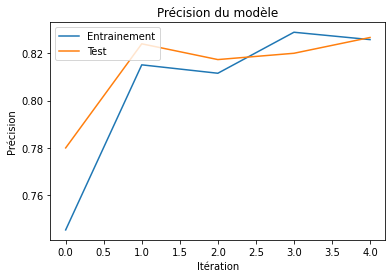

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle')
plt.ylabel('Précision')
plt.xlabel('Itération')
plt.legend(['Entrainement', 'Test'], loc='upper left')
plt.show()

# **Fine Tuning**

Afin d'obtenir une meilleur précision, on va également entrainer distilBERT : 

In [24]:
model.layers[2].trainable = True
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(1e-5), metrics=['accuracy'])
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 273)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 273)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_2 (TFDisti ((None, 273, 768), ( 66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 768)          0           tf_distil_bert_model_2

In [25]:
history = model.fit([output_tokenizer_entrainement['input_ids'],output_tokenizer_entrainement['attention_mask']],y_entrainement,
                    epochs=5, verbose=1, batch_size = 3,
                    validation_data=([output_tokenizer_tests['input_ids'],output_tokenizer_tests['attention_mask']],y_test))

Epoch 1/5
750/750 [==============================] - 85s 114ms/step - loss: 0.3706 - accuracy: 0.8356 - val_loss: 0.3417 - val_accuracy: 0.8667
Epoch 2/5
750/750 [==============================] - 87s 116ms/step - loss: 0.1593 - accuracy: 0.9329 - val_loss: 0.3125 - val_accuracy: 0.8880
Epoch 3/5
750/750 [==============================] - 88s 117ms/step - loss: 0.0635 - accuracy: 0.9769 - val_loss: 0.4711 - val_accuracy: 0.8653
Epoch 4/5
750/750 [==============================] - 89s 118ms/step - loss: 0.0241 - accuracy: 0.9907 - val_loss: 0.4908 - val_accuracy: 0.8773
Epoch 5/5
750/750 [==============================] - 89s 118ms/step - loss: 0.0358 - accuracy: 0.9898 - val_loss: 0.4185 - val_accuracy: 0.8920


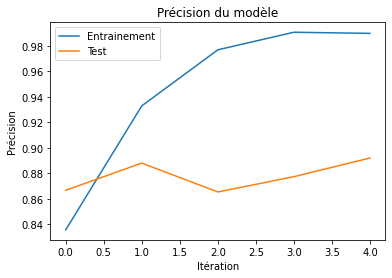

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle')
plt.ylabel('Précision')
plt.xlabel('Itération')
plt.legend(['Entrainement', 'Test'], loc='upper left')
plt.show()

# **Un modèle plus complexe**

Cette fois, les vecteurs de dimension 768 correspondants aux sorties [CLS] de chaque commentaire sont envoyés au même modèle que celui utilisé lors de l'activité avec GloVe :
<img src="https://raw.githubusercontent.com/AlexandreBourrieau/ML-F1/master/Carnets%20Jupyter/Images/ReseauDistilBERT3.png"/>

<img src="https://raw.githubusercontent.com/AlexandreBourrieau/ML-F1/master/Carnets%20Jupyter/Images/ReseauDistilBERT4.png"/>

In [27]:
dropout = 0.4

# Configuration du modèle distilBERT
config = DistilBertConfig(num_labels=2)           # 1 label
config.output_hidden_states = True               # Ne récupère pas la totalité des couches mais uniquement la dernière
config.output_attentions = False

# Instanciation du modèle distilBERT
transformer_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config = config)

# Défintion du format des entrées du modèle
entrees_ids = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='input_token', dtype='int32')
entrees_masks = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='masked_token', dtype='int32') 

# Création de la sortie du modèle
sortie_distilBERT = transformer_model([entrees_ids,entrees_masks])[0]

l1 = Lambda(lambda seq: seq[:, 0, :])(sortie_distilBERT)
l2 = Conv1D(128, 5, activation='relu', padding='same', strides=2)(tf.expand_dims(l1,axis=1))
l3 = GlobalMaxPooling1D()(l2)
l4 = Dropout(dropout)(l3)
l5 = Dense(128, activation='relu')(l4)
l6 = Dropout(dropout)(l5)
l7 = Dense(2, activation='softmax')(l6)

model = tf.keras.Model(inputs=[entrees_ids, entrees_masks], outputs = l7)
model.layers[2].trainable = False

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 273)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 273)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_3 (TFDisti ((None, 273, 768), ( 66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 768)          0           tf_distil_bert_model_3

In [28]:
history = model.fit([output_tokenizer_entrainement['input_ids'],output_tokenizer_entrainement['attention_mask']],y_entrainement,
                    epochs=5, verbose=1, batch_size = 3,
                    validation_data=([output_tokenizer_tests['input_ids'],output_tokenizer_tests['attention_mask']],y_test))

Epoch 1/5
750/750 [==============================] - 33s 44ms/step - loss: 0.5753 - accuracy: 0.6929 - val_loss: 0.4447 - val_accuracy: 0.7933
Epoch 2/5
750/750 [==============================] - 33s 43ms/step - loss: 0.4774 - accuracy: 0.7796 - val_loss: 0.4652 - val_accuracy: 0.7560
Epoch 3/5
750/750 [==============================] - 33s 44ms/step - loss: 0.4378 - accuracy: 0.8031 - val_loss: 0.3600 - val_accuracy: 0.8307
Epoch 4/5
750/750 [==============================] - 33s 45ms/step - loss: 0.4386 - accuracy: 0.7964 - val_loss: 0.3891 - val_accuracy: 0.8267
Epoch 5/5
750/750 [==============================] - 34s 45ms/step - loss: 0.4374 - accuracy: 0.7916 - val_loss: 0.3711 - val_accuracy: 0.8333


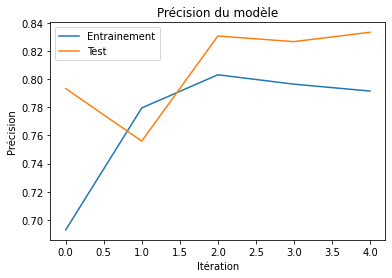

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle')
plt.ylabel('Précision')
plt.xlabel('Itération')
plt.legend(['Entrainement', 'Test'], loc='upper left')
plt.show()

**Fine-tuning**

Afin de tenter d'obtenir une meilleur précision, on va également entrainer distilBERT : 

In [30]:
model.layers[2].trainable = True
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(1e-5), metrics=['accuracy'])
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 273)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 273)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_3 (TFDisti ((None, 273, 768), ( 66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 768)          0           tf_distil_bert_model_3

In [31]:
history = model.fit([output_tokenizer_entrainement['input_ids'],output_tokenizer_entrainement['attention_mask']],y_entrainement,
                    epochs=5, verbose=1, batch_size = 3,
                    validation_data=([output_tokenizer_tests['input_ids'],output_tokenizer_tests['attention_mask']],y_test))

Epoch 1/5
750/750 [==============================] - 86s 115ms/step - loss: 0.3986 - accuracy: 0.8222 - val_loss: 0.3194 - val_accuracy: 0.8667
Epoch 2/5
750/750 [==============================] - 88s 117ms/step - loss: 0.2344 - accuracy: 0.9040 - val_loss: 0.3261 - val_accuracy: 0.8787
Epoch 3/5
750/750 [==============================] - 89s 118ms/step - loss: 0.0986 - accuracy: 0.9627 - val_loss: 0.5763 - val_accuracy: 0.8560
Epoch 4/5
750/750 [==============================] - 90s 119ms/step - loss: 0.0532 - accuracy: 0.9796 - val_loss: 0.5107 - val_accuracy: 0.8733
Epoch 5/5
750/750 [==============================] - 89s 119ms/step - loss: 0.0362 - accuracy: 0.9876 - val_loss: 0.6511 - val_accuracy: 0.8613


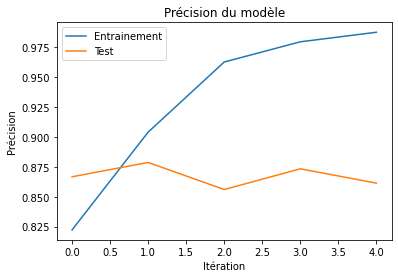

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle')
plt.ylabel('Précision')
plt.xlabel('Itération')
plt.legend(['Entrainement', 'Test'], loc='upper left')
plt.show()